# 02. Exploratory Data Analysis (EDA)

This notebook performs comprehensive exploratory data analysis on the cleaned ESG greenwashing dataset.

## Objectives
- Analyze claim categories and distributions
- Explore text characteristics and sentiment
- Investigate greenwashing patterns
- Analyze temporal trends
- Examine correlations between features
- Generate insights for modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import re
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed
np.random.seed(42)

In [2]:
# Load cleaned data
df = pd.read_parquet('../data/clean_claims.parquet')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (200, 20)


,project_id,organization_name,report_year,esg_claim_text,claim_category,claimed_metric_type,claimed_value,measurement_unit,project_location,actual_measured_value,value_deviation,external_validation_score,greenwashing_flag,controversy_flag,source_doc_link,report_sentiment_score,llm_claim_consistency_score,timestamp,text_length,word_count
0,SP-PROJ-0000,Acciona Renewables,2018,"In 2018, Acciona Renewables reported board div...",Governance,exec_comp_tied_to_esg,50.0,%,USA,58.82,8.82,81.0,0,0,https://example.com/esg-reports/SP-PROJ-0000,0.40,0.70,2024-10-03T12:19:10Z,71,11
1,SP-PROJ-0001,Acciona Renewables,2019,"In 2019, Acciona Renewables reported local com...",Social,community_investment,10.0,million USD,Canada,11.87,1.87,60.3,0,0,https://example.com/esg-reports/SP-PROJ-0001,0.24,0.89,2024-12-20T12:19:10Z,80,11
2,SP-PROJ-0002,Iberdrola Green Energy,2024,"In 2024, Iberdrola Green Energy reported local...",Social,supplier_diversity,2.0,million USD,South Africa,1.98,-0.02,81.2,0,0,https://example.com/esg-reports/SP-PROJ-0002,0.59,0.69,2025-04-11T12:19:10Z,85,12
3,SP-PROJ-0003,Repsol Low Carbon,2022,"In 2022, Repsol Low Carbon reported board dive...",Governance,board_independence,60.0,%,Canada,64.57,4.57,76.8,0,0,https://example.com/esg-reports/SP-PROJ-0003,-0.13,0.45,2024-09-22T12:19:10Z,66,12
4,SP-PROJ-0004,Acciona Renewables,2018,"In 2018, Acciona Renewables reported training ...",Social,supplier_diversity,20.0,million USD,India,20.89,0.89,80.0,0,0,https://example.com/esg-reports/SP-PROJ-0004,0.78,0.84,2025-05-15T12:19:10Z,73,11


## 1. Dataset Overview

In [3]:
# Basic dataset information
print("=== DATASET OVERVIEW ===\n")
print(f"Total records: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Date range: {df['report_year'].min()} - {df['report_year'].max()}")
print(f"Unique organizations: {df['organization_name'].nunique():,}")
print(f"Unique locations: {df['project_location'].nunique():,}")
print(f"Greenwashing rate: {df['greenwashing_flag'].mean():.2%}")

# Display data types
print("\nData Types:")
print(df.dtypes)

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\nMissing values:")
    print(missing[missing > 0])
else:
    print("\nNo missing values found.")

=== DATASET OVERVIEW ===

Total records: 200
Total features: 20
Date range: 2015 - 2024
Unique organizations: 15
Unique locations: 10
Greenwashing rate: 38.00%

Data Types:
project_id                      object
organization_name               object
report_year                      int64
esg_claim_text                  object
claim_category                  object
claimed_metric_type             object
claimed_value                  float64
measurement_unit                object
project_location                object
actual_measured_value          float64
value_deviation                float64
external_validation_score      float64
greenwashing_flag                int64
controversy_flag                 int64
source_doc_link                 object
report_sentiment_score         float64
llm_claim_consistency_score    float64
timestamp                       object
text_length                      int64
word_count                       int64
dtype: object

No missing values found.


## 2. Claim Categories Analysis

=== CLAIM CATEGORIES ANALYSIS ===

Category Distribution:
Governance: 54 (27.0%)
Social: 53 (26.5%)
Environmental: 52 (26.0%)
Other: 41 (20.5%)

Greenwashing Rate by Category:
Governance: 29.63% (54 claims)
Social: 50.94% (53 claims)
Environmental: 34.62% (52 claims)
Other: 36.59% (41 claims)


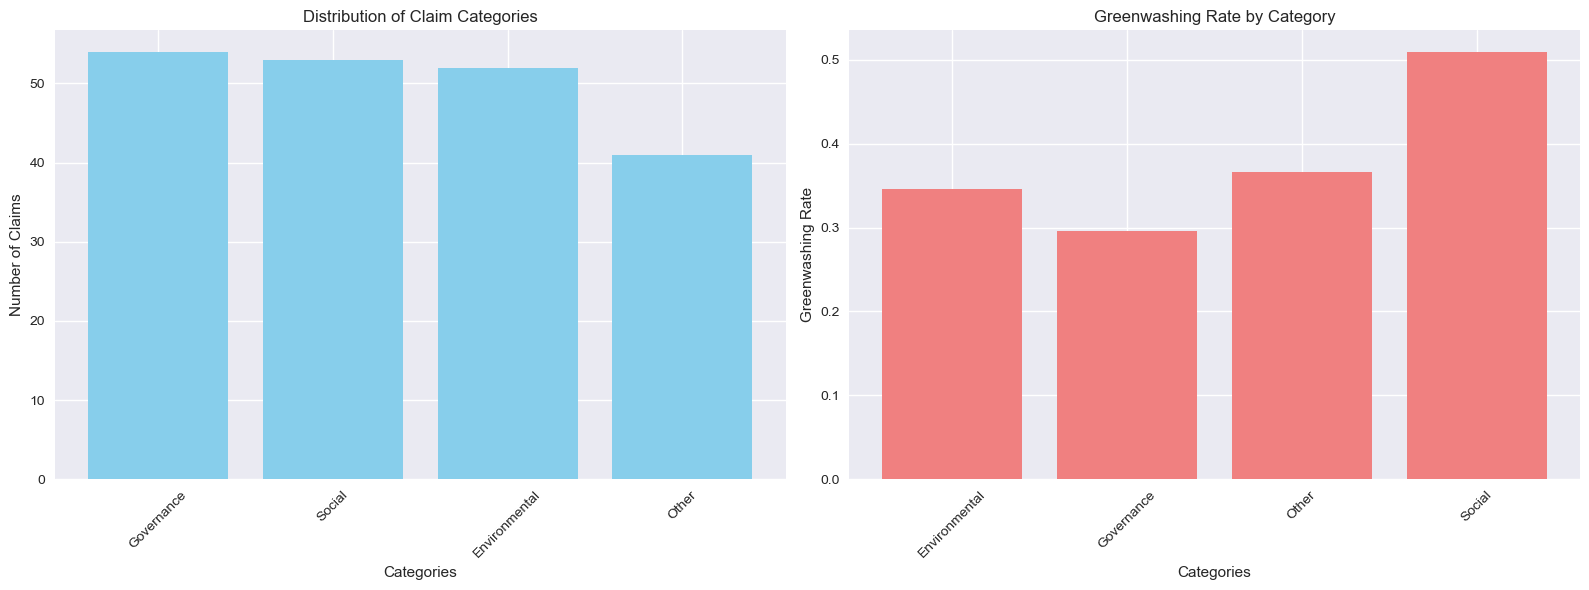

In [4]:
# Analyze claim categories
category_counts = df['claim_category'].value_counts()
category_greenwashing = df.groupby('claim_category')['greenwashing_flag'].agg(['mean', 'count'])

print("=== CLAIM CATEGORIES ANALYSIS ===\n")
print("Category Distribution:")
for cat, count in category_counts.items():
    print(f"{cat}: {count} ({count/len(df)*100:.1f}%)")

print("\nGreenwashing Rate by Category:")
for cat in category_counts.index:
    rate = category_greenwashing.loc[cat, 'mean']
    count = category_greenwashing.loc[cat, 'count']
    print(f"{cat}: {rate:.2%} ({count} claims)")

# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category counts
axes[0].bar(range(len(category_counts)), category_counts.values, color='skyblue')
axes[0].set_title('Distribution of Claim Categories')
axes[0].set_xlabel('Categories')
axes[0].set_ylabel('Number of Claims')
axes[0].set_xticks(range(len(category_counts)))
axes[0].set_xticklabels(category_counts.index, rotation=45)

# Greenwashing rate by category
axes[1].bar(range(len(category_greenwashing)), category_greenwashing['mean'], color='lightcoral')
axes[1].set_title('Greenwashing Rate by Category')
axes[1].set_xlabel('Categories')
axes[1].set_ylabel('Greenwashing Rate')
axes[1].set_xticks(range(len(category_greenwashing)))
axes[1].set_xticklabels(category_greenwashing.index, rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Text Analysis

=== TEXT ANALYSIS ===

Text Length Statistics:
       text_length  word_count
count   200.000000  200.000000
mean     77.570000   11.380000
std       8.007854    1.149874
min      60.000000    9.000000
25%      71.000000   11.000000
50%      78.000000   11.000000
75%      84.000000   12.000000
max      96.000000   14.000000

Average text length:
Greenwashing claims: 78.9 characters
Legitimate claims: 76.8 characters


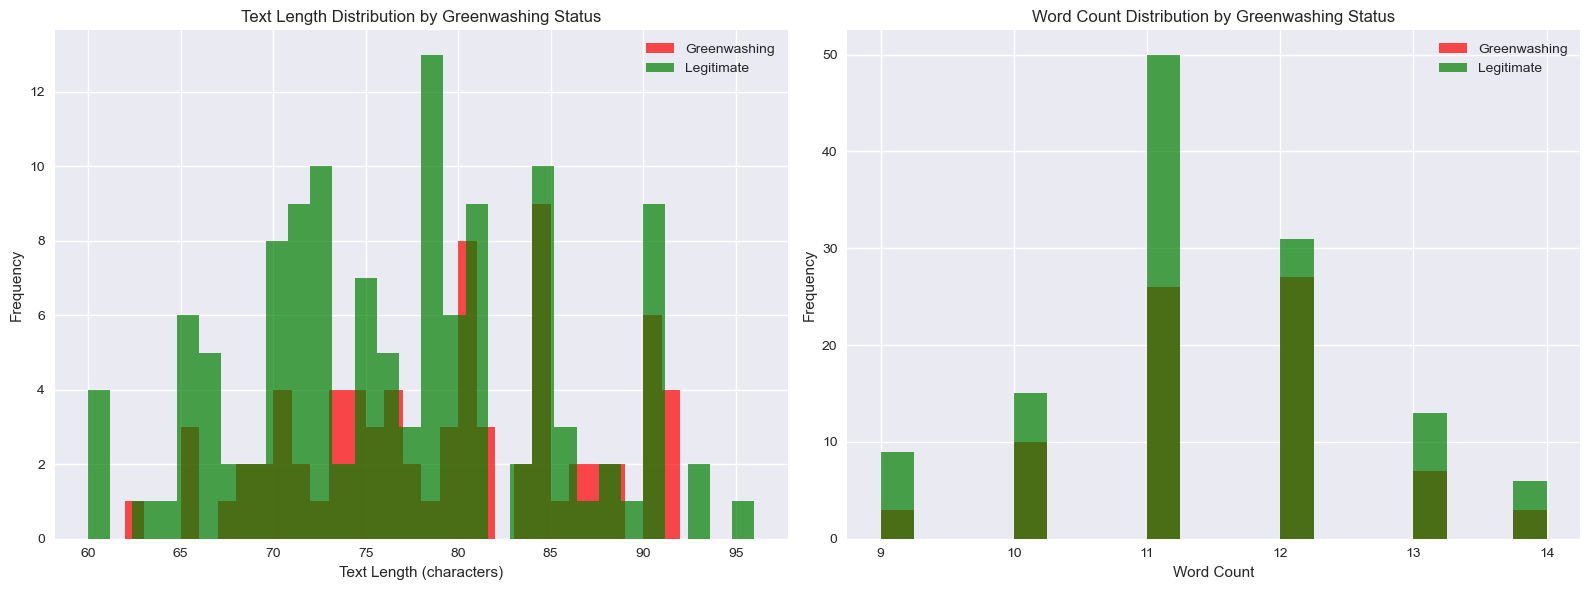

In [5]:
# Text length analysis
df['text_length'] = df['esg_claim_text'].str.len()
df['word_count'] = df['esg_claim_text'].str.split().str.len()

print("=== TEXT ANALYSIS ===\n")
print("Text Length Statistics:")
print(df[['text_length', 'word_count']].describe())

# Text length by greenwashing status
greenwashing_texts = df[df['greenwashing_flag'] == 1]
legitimate_texts = df[df['greenwashing_flag'] == 0]

print(f"\nAverage text length:")
print(f"Greenwashing claims: {greenwashing_texts['text_length'].mean():.1f} characters")
print(f"Legitimate claims: {legitimate_texts['text_length'].mean():.1f} characters")

# Visualize text length distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(greenwashing_texts['text_length'], bins=30, alpha=0.7, label='Greenwashing', color='red')
axes[0].hist(legitimate_texts['text_length'], bins=30, alpha=0.7, label='Legitimate', color='green')
axes[0].set_title('Text Length Distribution by Greenwashing Status')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(greenwashing_texts['word_count'], bins=20, alpha=0.7, label='Greenwashing', color='red')
axes[1].hist(legitimate_texts['word_count'], bins=20, alpha=0.7, label='Legitimate', color='green')
axes[1].set_title('Word Count Distribution by Greenwashing Status')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/text_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Sentiment Analysis

=== SENTIMENT ANALYSIS ===

Sentiment Score Statistics:
count    200.000000
mean       0.302300
std        0.282197
min       -0.180000
25%        0.070000
50%        0.300000
75%        0.532500
max        0.780000
Name: report_sentiment_score, dtype: float64

Sentiment by Greenwashing Status:
Greenwashing claims: 0.316
Legitimate claims: 0.294


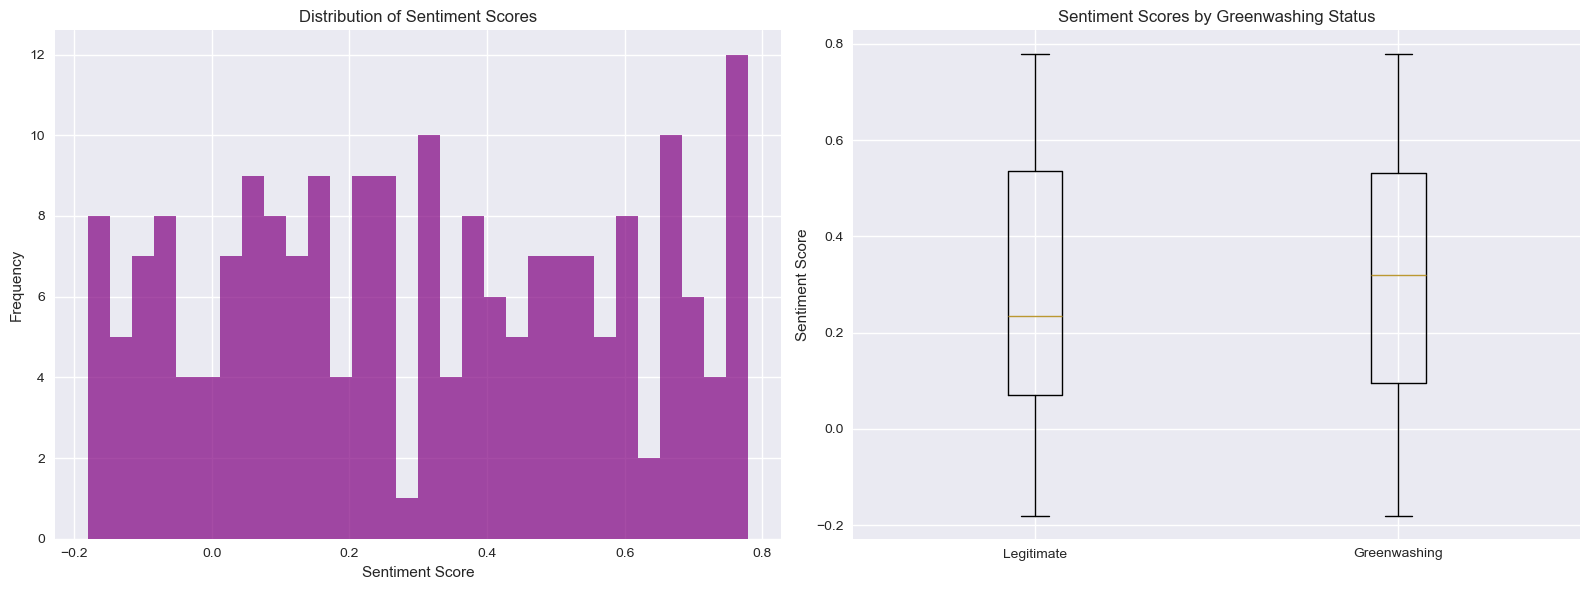

In [6]:
# Analyze sentiment scores
print("=== SENTIMENT ANALYSIS ===\n")
print("Sentiment Score Statistics:")
print(df['report_sentiment_score'].describe())

# Sentiment by greenwashing status
print(f"\nSentiment by Greenwashing Status:")
print(f"Greenwashing claims: {greenwashing_texts['report_sentiment_score'].mean():.3f}")
print(f"Legitimate claims: {legitimate_texts['report_sentiment_score'].mean():.3f}")

# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(df['report_sentiment_score'], bins=30, alpha=0.7, color='purple')
axes[0].set_title('Distribution of Sentiment Scores')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')

axes[1].boxplot([legitimate_texts['report_sentiment_score'], 
                 greenwashing_texts['report_sentiment_score']], 
                labels=['Legitimate', 'Greenwashing'])
axes[1].set_title('Sentiment Scores by Greenwashing Status')
axes[1].set_ylabel('Sentiment Score')

plt.tight_layout()
plt.savefig('../reports/figures/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Temporal Analysis

=== TEMPORAL ANALYSIS ===

Claims by Year:
2015: 15 claims
2016: 9 claims
2017: 6 claims
2018: 27 claims
2019: 27 claims
2020: 20 claims
2021: 26 claims
2022: 26 claims
2023: 24 claims
2024: 20 claims

Greenwashing Rate by Year:
2015: 26.67% (15 claims)
2016: 22.22% (9 claims)
2017: 33.33% (6 claims)
2018: 37.04% (27 claims)
2019: 37.04% (27 claims)
2020: 40.00% (20 claims)
2021: 50.00% (26 claims)
2022: 50.00% (26 claims)
2023: 25.00% (24 claims)
2024: 40.00% (20 claims)


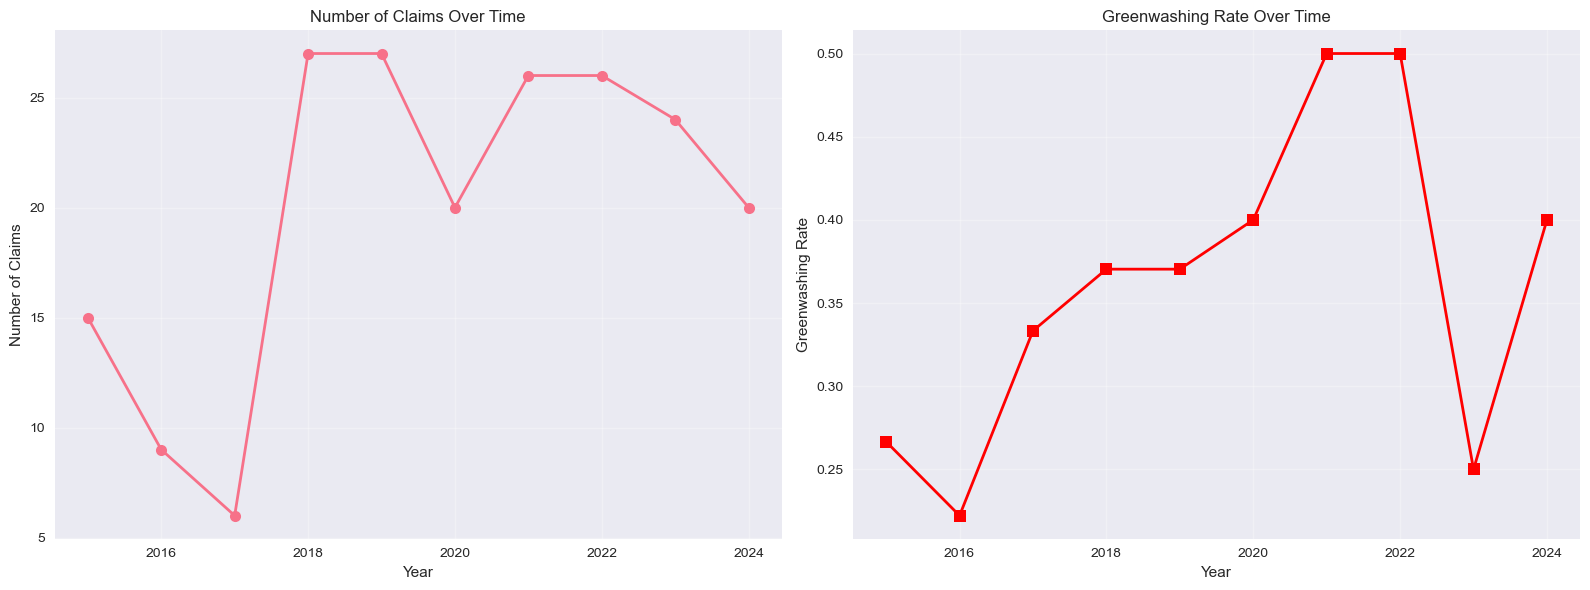

In [7]:
# Analyze trends over time
print("=== TEMPORAL ANALYSIS ===\n")

# Claims over time
yearly_counts = df['report_year'].value_counts().sort_index()
yearly_greenwashing = df.groupby('report_year')['greenwashing_flag'].agg(['mean', 'count'])

print("Claims by Year:")
for year, count in yearly_counts.items():
    print(f"{year}: {count} claims")

print("\nGreenwashing Rate by Year:")
for year in yearly_counts.index:
    rate = yearly_greenwashing.loc[year, 'mean']
    count = yearly_greenwashing.loc[year, 'count']
    print(f"{year}: {rate:.2%} ({count} claims)")

# Visualize temporal trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Number of Claims Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Claims')
axes[0].grid(True, alpha=0.3)

axes[1].plot(yearly_greenwashing.index, yearly_greenwashing['mean'], marker='s', linewidth=2, markersize=8, color='red')
axes[1].set_title('Greenwashing Rate Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Greenwashing Rate')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Organization Analysis

=== ORGANIZATION ANALYSIS ===

Top 10 Organizations by Claim Count:
Grenergy Renovables: 27 claims
Ferrovial Sustainable Infra: 23 claims
Acciona Renewables: 20 claims
Iberdrola Green Energy: 19 claims
Naturgy Solar Ventures: 18 claims
Solaria Energía: 14 claims
Cepsa Transition Tech: 13 claims
Repsol Low Carbon: 12 claims
Endesa Transition Projects: 12 claims
Red Eléctrica Verde: 11 claims

Organizations with Highest Greenwashing Rate (≥3 claims):
Cobalt Health Inc.: 66.67% (6 claims)
Cepsa Transition Tech: 61.54% (13 claims)
Red Eléctrica Verde: 54.55% (11 claims)
Iberdrola Green Energy: 52.63% (19 claims)
Helios Tech Holdings: 50.00% (6 claims)
Solaria Energía: 42.86% (14 claims)
Naturgy Solar Ventures: 38.89% (18 claims)
Ferrovial Sustainable Infra: 34.78% (23 claims)
Aurora Energy plc: 33.33% (6 claims)
Endesa Transition Projects: 33.33% (12 claims)


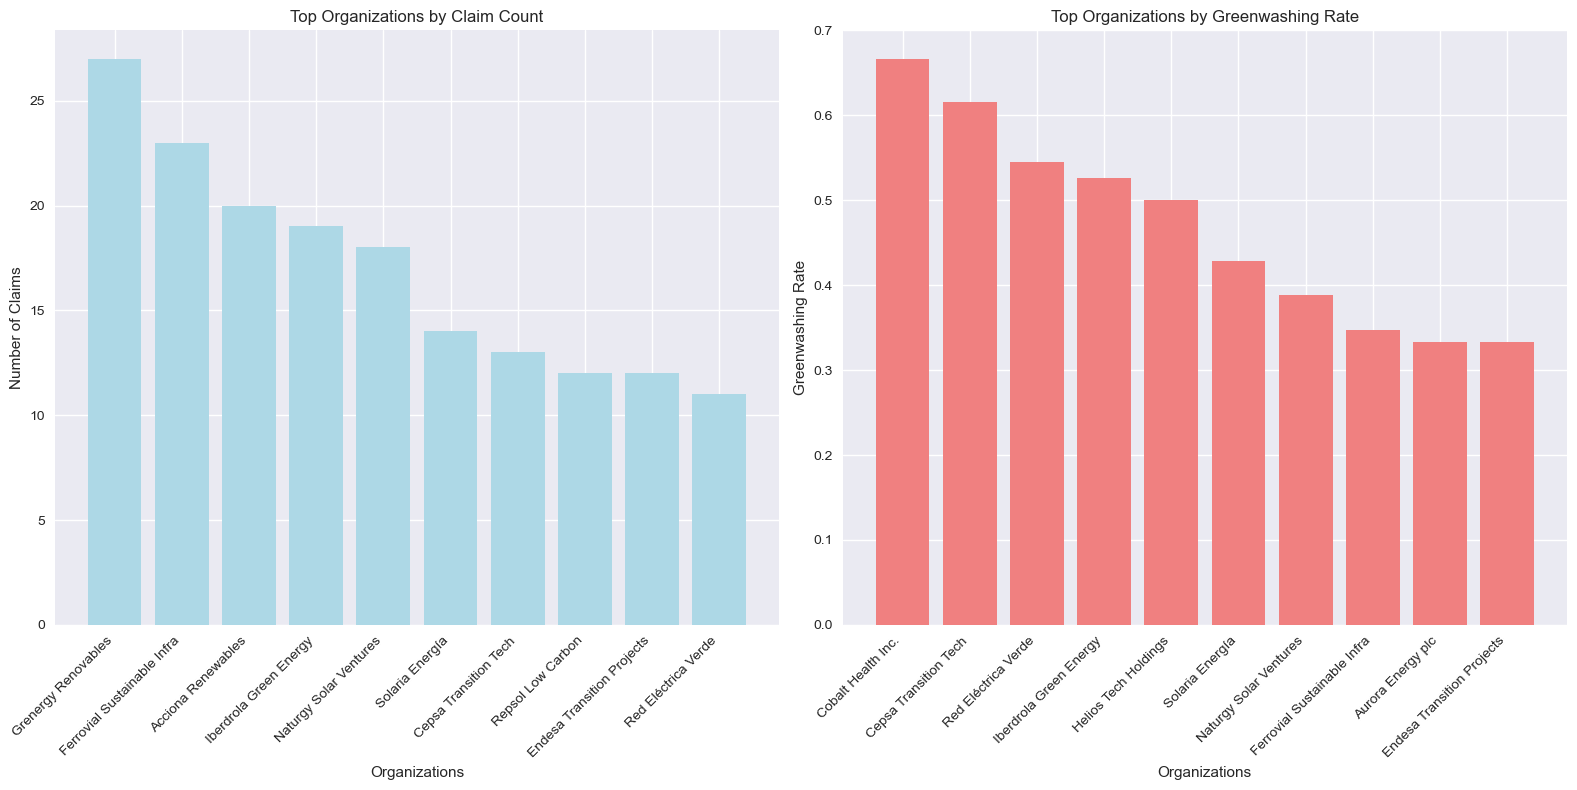

In [8]:
# Analyze organizations
print("=== ORGANIZATION ANALYSIS ===\n")

# Top organizations by claim count
org_counts = df['organization_name'].value_counts().head(10)
org_greenwashing = df.groupby('organization_name')['greenwashing_flag'].agg(['mean', 'count'])
org_greenwashing = org_greenwashing[org_greenwashing['count'] >= 3].sort_values('mean', ascending=False)

print("Top 10 Organizations by Claim Count:")
for org, count in org_counts.items():
    print(f"{org}: {count} claims")

print("\nOrganizations with Highest Greenwashing Rate (≥3 claims):")
for org in org_greenwashing.head(10).index:
    rate = org_greenwashing.loc[org, 'mean']
    count = org_greenwashing.loc[org, 'count']
    print(f"{org}: {rate:.2%} ({count} claims)")

# Visualize organization analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].bar(range(len(org_counts)), org_counts.values, color='lightblue')
axes[0].set_title('Top Organizations by Claim Count')
axes[0].set_xlabel('Organizations')
axes[0].set_ylabel('Number of Claims')
axes[0].set_xticks(range(len(org_counts)))
axes[0].set_xticklabels(org_counts.index, rotation=45, ha='right')

top_orgs_greenwashing = org_greenwashing.head(10)
axes[1].bar(range(len(top_orgs_greenwashing)), top_orgs_greenwashing['mean'], color='lightcoral')
axes[1].set_title('Top Organizations by Greenwashing Rate')
axes[1].set_xlabel('Organizations')
axes[1].set_ylabel('Greenwashing Rate')
axes[1].set_xticks(range(len(top_orgs_greenwashing)))
axes[1].set_xticklabels(top_orgs_greenwashing.index, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../reports/figures/organization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Correlation Analysis

=== CORRELATION ANALYSIS ===

Correlation with Greenwashing Flag:
text_length: 0.129
word_count: 0.046
report_sentiment_score: 0.039
llm_claim_consistency_score: -0.005
external_validation_score: -0.113
claimed_value: -0.139
actual_measured_value: -0.215
value_deviation: -0.531


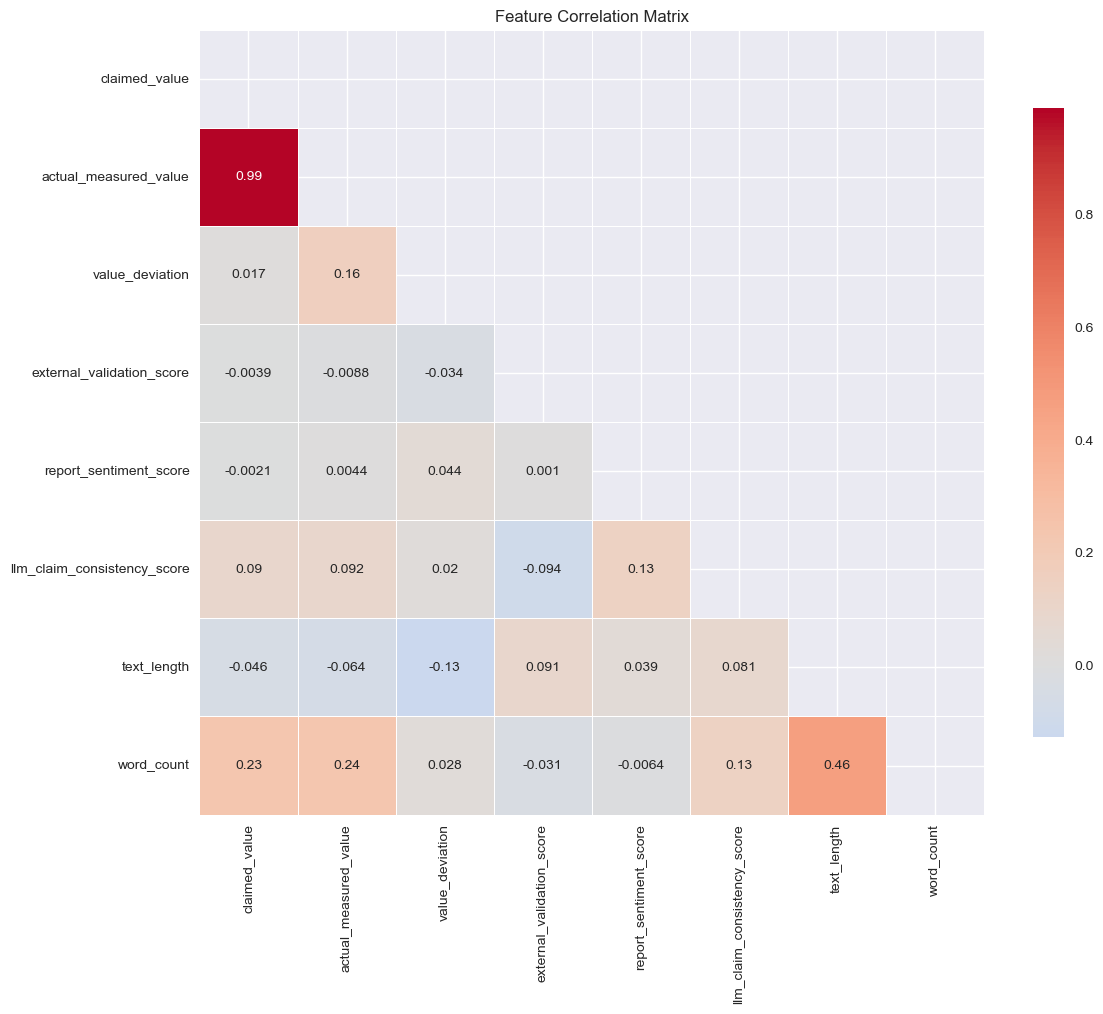

In [9]:
# Analyze correlations between numeric features
numeric_cols = ['claimed_value', 'actual_measured_value', 'value_deviation', 
                'external_validation_score', 'report_sentiment_score', 
                'llm_claim_consistency_score', 'text_length', 'word_count']

correlation_matrix = df[numeric_cols].corr()

print("=== CORRELATION ANALYSIS ===\n")
print("Correlation with Greenwashing Flag:")
greenwashing_corr = df[numeric_cols + ['greenwashing_flag']].corr()['greenwashing_flag'].sort_values(ascending=False)
for feature, corr in greenwashing_corr.items():
    if feature != 'greenwashing_flag':
        print(f"{feature}: {corr:.3f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Key Insights Summary

In [10]:
# Generate insights summary
print("=== KEY INSIGHTS SUMMARY ===\n")

print("1. DATASET CHARACTERISTICS:")
print(f"   - Total claims: {len(df):,}")
print(f"   - Greenwashing rate: {df['greenwashing_flag'].mean():.2%}")
print(f"   - Date range: {df['report_year'].min()} - {df['report_year'].max()}")
print(f"   - Organizations: {df['organization_name'].nunique():,}")

print("\n2. CATEGORY INSIGHTS:")
most_common_cat = category_counts.index[0]
highest_greenwashing_cat = category_greenwashing['mean'].idxmax()
print(f"   - Most common category: {most_common_cat} ({category_counts.iloc[0]} claims)")
print(f"   - Highest greenwashing rate: {highest_greenwashing_cat} ({category_greenwashing.loc[highest_greenwashing_cat, 'mean']:.2%})")

print("\n3. TEXT INSIGHTS:")
print(f"   - Average text length: {df['text_length'].mean():.1f} characters")
print(f"   - Greenwashing texts are {'longer' if greenwashing_texts['text_length'].mean() > legitimate_texts['text_length'].mean() else 'shorter'} than legitimate texts")

print("\n4. TEMPORAL INSIGHTS:")
if len(yearly_counts) > 1:
    trend = "increasing" if yearly_greenwashing['mean'].iloc[-1] > yearly_greenwashing['mean'].iloc[0] else "decreasing"
    print(f"   - Greenwashing rate trend: {trend}")
    print(f"   - Peak year: {yearly_greenwashing['mean'].idxmax()} ({yearly_greenwashing['mean'].max():.2%})")

print("\n5. CORRELATION INSIGHTS:")
strongest_corr_feature = greenwashing_corr.index[1]  # Skip greenwashing_flag itself
strongest_corr_value = greenwashing_corr.iloc[1]
print(f"   - Strongest correlation with greenwashing: {strongest_corr_feature} ({strongest_corr_value:.3f})")

print("\n6. MODELING RECOMMENDATIONS:")
print("   - Use text length and sentiment as important features")
print("   - Consider temporal patterns in model training")
print("   - Include organization-level features")
print("   - Focus on categories with high greenwashing rates")

# Save insights
insights = {
    'total_claims': len(df),
    'greenwashing_rate': df['greenwashing_flag'].mean(),
    'date_range': [df['report_year'].min(), df['report_year'].max()],
    'organizations': df['organization_name'].nunique(),
    'most_common_category': most_common_cat,
    'highest_greenwashing_category': highest_greenwashing_cat,
    'avg_text_length': df['text_length'].mean(),
    'strongest_correlation': {
        'feature': strongest_corr_feature,
        'correlation': strongest_corr_value
    }
}

import json
with open('../reports/eda_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)
print("\nInsights saved to ../reports/eda_insights.json")

=== KEY INSIGHTS SUMMARY ===

1. DATASET CHARACTERISTICS:
   - Total claims: 200
   - Greenwashing rate: 38.00%
   - Date range: 2015 - 2024
   - Organizations: 15

2. CATEGORY INSIGHTS:
   - Most common category: Governance (54 claims)
   - Highest greenwashing rate: Social (50.94%)

3. TEXT INSIGHTS:
   - Average text length: 77.6 characters
   - Greenwashing texts are longer than legitimate texts

4. TEMPORAL INSIGHTS:
   - Greenwashing rate trend: increasing
   - Peak year: 2021 (50.00%)

5. CORRELATION INSIGHTS:
   - Strongest correlation with greenwashing: text_length (0.129)

6. MODELING RECOMMENDATIONS:
   - Use text length and sentiment as important features
   - Consider temporal patterns in model training
   - Include organization-level features
   - Focus on categories with high greenwashing rates

Insights saved to ../reports/eda_insights.json
